The empirical exercise should focus on how the sector and factor tilting works when a crisis comes, better diversification provided, consistent risk factor contributions, and greater resilience to economic shocks 

In [67]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from itertools import product
from regimeaware.core import utils

# rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)
rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq='Q')

# Data
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
mktcap = crsp['mktcap'].copy()
ref_wts = mktcap.groupby('permno').shift(1).reindex(factor_loadings.index.droplevel('factor').unique())
ref_wts = ref_wts.div(ref_wts.groupby('date').sum())

bm = ref_wts.groupby('id').shift(1).mul(crsp['excess_ret'].reindex(ref_wts.index)).groupby('date').sum().add(1).cumprod()

$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

Gamma: 5\nTE Budget: 6.0   -0.120994
Gamma: 2\nTE Budget: 6.0    0.144684
Gamma: 1\nTE Budget: 6.0    0.180734
Gamma: 5\nTE Budget: 7.5    1.021602
Gamma: 2\nTE Budget: 7.5    1.221439
Gamma: 1\nTE Budget: 7.5    1.248677
dtype: float64

Gamma: 1\nTE Budget: 7.5    5.547145
Gamma: 2\nTE Budget: 7.5    5.552086
Gamma: 5\nTE Budget: 7.5    5.580098
Gamma: 1\nTE Budget: 6.0    5.658422
Gamma: 2\nTE Budget: 6.0    5.661902
Gamma: 5\nTE Budget: 6.0    5.681759
Benchmark                   5.945814
dtype: float64

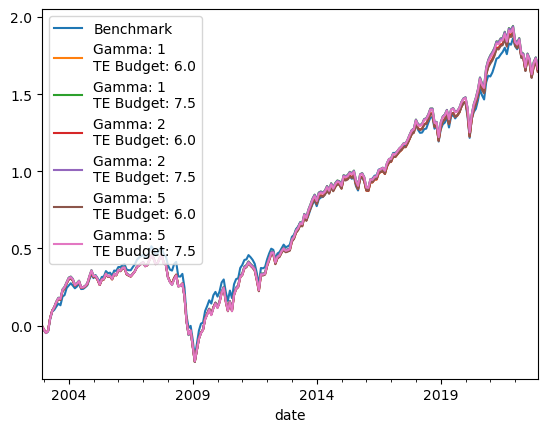

In [8]:
collect_w = {}

for g, t, dt in product(cfg.gamma_iter, cfg.tev_budget_iter, rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ w,
        w >= 0,
        tracking_error <= tev_budget 
    ]

    gamma.value = g
    tev_budget.value = (t / 12) ** 2 

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['tev', 'gamma', 'date']

collect_bt = {}
for g, t in product(cfg.gamma_iter, cfg.tev_budget_iter):
    wt = wts.xs(t).xs(g)
    collect_bt[(g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}\nTE Budget: {y * 100}' for x,y in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
display(tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values())
display(df.mean().div(df.std()).mul(np.sqrt(12)).sort_values())

In [74]:
rt.add(1).groupby(pd.Grouper(freq='Q')).prod().sub(1).replace(0, np.nan)

permno,10000.0,10001.0,10002.0,10003.0,10005.0,10006.0,10007.0,10008.0,10009.0,10010.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
date,,,,,,,,,,,,,,,,,,,,,
1963-09-30,NaN,NaN,NaN,NaN,NaN,-0.020553,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-12-31,NaN,NaN,NaN,NaN,NaN,0.303406,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-03-31,NaN,NaN,NaN,NaN,NaN,0.105982,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-06-30,NaN,NaN,NaN,NaN,NaN,0.058977,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-09-30,NaN,NaN,NaN,NaN,NaN,0.159221,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001796,0.067488,NaN,0.056616,NaN,NaN,NaN,0.053941,NaN,0.362596
2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021504,-0.133975,NaN,-0.119045,NaN,NaN,NaN,-0.219864,NaN,0.019619
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.501806,-0.094874,NaN,-0.007512,NaN,NaN,NaN,-0.531100,NaN,-0.375789


Gamma: 5     0.074102
Gamma: 50    0.093061
Gamma: 35    0.102873
Gamma: 30    0.106682
Gamma: 10    0.108049
Gamma: 25    0.112718
Gamma: 15    0.115931
Gamma: 20    0.117457
dtype: float64

Gamma: 5     0.409970
Gamma: 10    0.487177
Gamma: 15    0.522301
Gamma: 20    0.542834
Gamma: 25    0.553947
Gamma: 30    0.561083
Gamma: 35    0.567894
Gamma: 50    0.581773
Benchmark    0.635878
dtype: float64

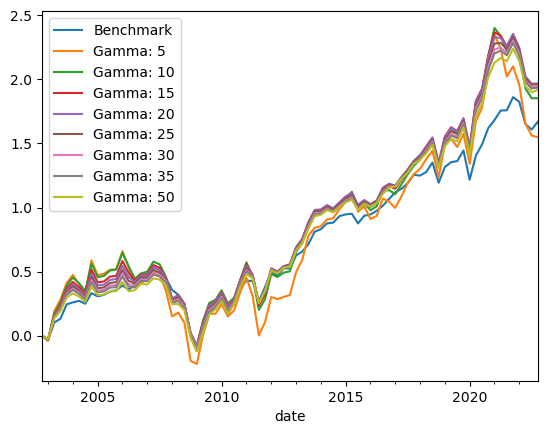

In [77]:
collect_w = {}
test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for g, dt in product(test_g, rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = g

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['gamma', 'date']

collect_bt = {}
for g in test_g:
    wt = wts.xs(g)
    collect_bt[g] = wt.shift(1).mul(rt.add(1).groupby(pd.Grouper(freq='Q')).prod().sub(1).replace(0, np.nan)).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}' for x in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.resample('Q').last().apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
display(tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values())
display(df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12)).sort_values())

# TODO: Just work without the TEV constraint, in relative weights terms, and just control the gamma

Obs
- Higher TEV-Budget leads to better IR
- Higher risk aversion leads to lower IR? 

<Axes: xlabel='as_of'>

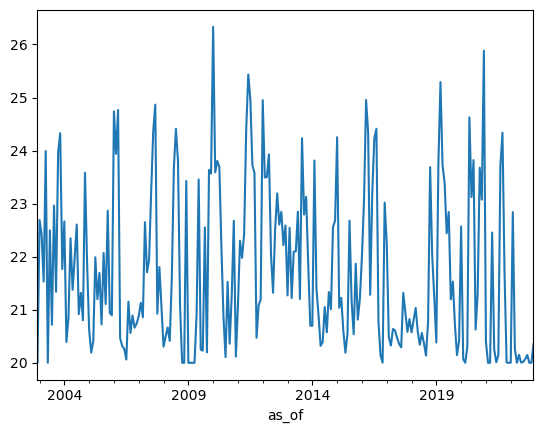

In [27]:
from scipy.stats import entropy

transmat = pd.read_pickle(f'{cfg.data_fldr}/regimes/transmat.pkl')
emission_prob = pd.read_pickle(f'{cfg.data_fldr}/regimes/emission_prob.pkl')
h = emission_prob.groupby('as_of').last().apply(entropy, axis=1)
h.mul(5).add(20).plot()

IR


Backtest    0.071606
dtype: float64

0.12218257891384982

SR


Backtest     0.403961
Benchmark    0.437529
dtype: float64

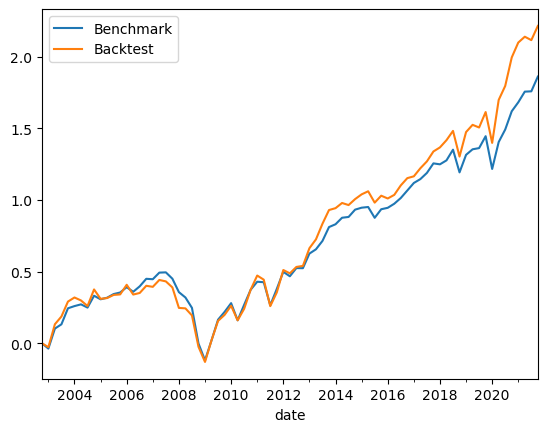

In [83]:
collect_w = {}
# test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for dt in rebalance_dts:
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = h[dt] * 10 + 55

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[dt] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['date']
bt = wts.shift(1).mul(rt.add(1).groupby(pd.Grouper(freq='Q')).prod().sub(1).replace(0, np.nan)).dropna(how='all').sum(axis=1)
bt = bt.reindex(bm.index).fillna(0)
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod().rename('Backtest'))
df.apply(np.log).resample('Q').last().loc[:'2021'].plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1).loc[:'2021']
print('IR')
display(tracking.mean().div(tracking.std()).mul(np.sqrt(4)).sort_values())
display(tracking.std().item() * np.sqrt(4))
print('SR')
display(df.loc[:'2021'].pct_change().mean().div(df.loc[:'2021'].pct_change().std()).mul(np.sqrt(4)).sort_values())


IR


Backtest    0.036303
dtype: float64

0.07024460963693617

SR


Backtest     0.568626
Benchmark    0.635878
dtype: float64

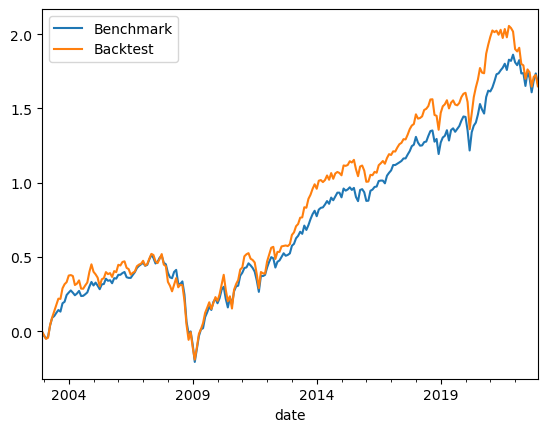

In [66]:
collect_w = {}
# test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for dt in rebalance_dts:
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = h[dt] * 5 + 25

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[dt] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['date']
bt = wts.shift(1).mul(rt).dropna(how='all').sum(axis=1)
bt = bt.reindex(bm.index).fillna(0)
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod().rename('Backtest'))
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
print('IR')
display(tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values())
display(tracking.std().item() * np.sqrt(12))
print('SR')
display(df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12)).sort_values())


IR


Backtest    0.051312
dtype: float64

0.058856692337858625

SR


Backtest     5.330310
Benchmark    5.945814
dtype: float64

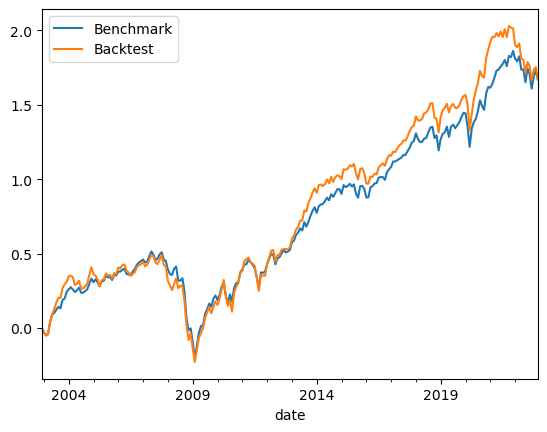

In [62]:
collect_w = {}
# test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for dt in rebalance_dts:
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = h[dt] * 10 + 40

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[dt] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['date']
bt = wts.shift(1).mul(rt).dropna(how='all').sum(axis=1)
bt = bt.reindex(bm.index).fillna(0)
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod().rename('Backtest'))
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
print('IR')
display(tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values())
display(tracking.std().item() * np.sqrt(12))
print('SR')
display(df.mean().div(df.std()).mul(np.sqrt(12)).sort_values())


In [ ]:
collect_w = {}

# for t, dt in product(cfg.tev_budget_iter, rebalance_dts):
for t, dt in product([.01, .05, .1, .2, .3, .4, .5], rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ w,
        w >= 0,
        tracking_error <= tev_budget 
    ]
    g = h.xs(dt) * 3 + .5  # <--------------------------------
    gamma.value = g
    tev_budget.value = (t / 12) ** 2 

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(t, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['tev', 'date']

In [ ]:
collect_bt = {}
# for t in cfg.tev_budget_iter:
for t in [.01, .05, .1, .2, .3, .4, .5]:
    wt = wts.xs(t)
    collect_bt[t] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: x\nTE Budget: {x * 100}' for x in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
display((tracking.mean() / tracking.std() * np.sqrt(12)).sort_values())

display((df.pct_change().mean() / df.pct_change().std() * np.sqrt(12)).sort_values())

In [ ]:
"""
MVO is giving issues because the matrix is not invertible
When I do dropna gives me back two obervations, which should be wrong, as the tradabale securities have betas, and to have a beta we require 10 years of obervations (120 obs)
For this reason, I'd expect each stock to have the last 120 obs valid

Confirmed, the matrix is not invertible and that was causing the issues while optimizing

Compared to: Historical beta estimation
"""

In [ ]:
collect_w = {}

for window in cfg.ols_windows:
    factor_loadings_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_betas_{window}.pkl')
    factor_variance_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_var_{window}.pkl')
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            for dt in tqdm(rebalance_dts, desc=f'window: {window}, gamma: {g}, te budget: {t * 100}%'):
                # Data handling
                sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
                
                factor_sample = rt_ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].iloc[-window:]
                mu_f = factor_sample.mean().values.reshape(-1, 1)
                mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
                Sigma_f = factor_sample.cov().values
                
                
                F = utils.unpack_betas(factor_loadings_ols.xs(dt)).reindex(sec_ids).values.T
                E = np.diag(factor_variance_ols.xs(dt).reindex(sec_ids))
                b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
                b = np.divide(b, b.sum())

                # Optimization problem
                tev_budget = cp.Parameter(nonneg=True)
                gamma = cp.Parameter(nonneg=True)

                m, n = F.shape
                w = cp.Variable((n, 1))
                f = cp.Variable((m, 1))

                Sigma_f_const = np.zeros((m, m))
                Sigma_f_const[1:, 1:] = Sigma_f

                tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
                port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
                port_return = mu_f_const.T @ f

                constraints = [
                    cp.sum(w) == 1,
                    f == F @ w,
                    w >= 0,
                    tracking_error <= tev_budget 
                ]

                gamma.value = g
                tev_budget.value = (t / 12) ** 2 

                prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
                prob.solve(verbose=False, solver=cp.CLARABEL)
                collect_w[(window, t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


In [ ]:
wts

In [ ]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for w in cfg.ols_windows:
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            wt = wts.xs(w).xs(t).xs(g)
            collect_bt[(w, g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt_ols = pd.DataFrame.from_dict(collect_bt)
bt_ols = bt_ols.reindex(bm.index).fillna(0)
bt_ols.columns = [f'OLS-{w}M Gamma: {x}\nTE Budget: {y * 100}' for w, x, y in bt_ols.columns]

In [ ]:
df = bm.to_frame(name='Benchmark').join(bt_ols.add(1).cumprod())
df.apply(np.log).plot()

In [ ]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

In [ ]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()